In [1]:
from pycocotools.coco import COCO
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import PIL
import torch
import sys
import os
import cv2
import argparse
import matplotlib.pyplot as plt
import torchvision.transforms as T

from PIL import Image
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

from classifier import multilabel_classifier
from load_data import *

###                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
# Referenced from:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
# https://github.com/jacobgil/pytorch-grad-cam/blob/master/gradcam.py                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
#                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
# Example usage:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
# python get_cams.py --modelpath $MODELPATH --img_ids 535811 430054 554674                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
#                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
# --modelpath: path to the model to visualize                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
# --img_ids: COCOStuff image IDs (use the Explore tool on the COCO dataset website)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
###                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

def get_heatmap(CAM_map, img):
    CAM_map = cv2.resize(CAM_map, (img.shape[0], img.shape[1]))
    CAM_map = CAM_map - np.min(CAM_map)
    CAM_map = CAM_map / np.max(CAM_map)
    CAM_map = 1.0 - CAM_map # make sure colormap is not reversed                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
    heatmap = cv2.applyColorMap(np.uint8(255 * CAM_map), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    #heatmap = heatmap + np.float32(img)
    heatmap = heatmap / np.max(heatmap)
    heatmap = np.uint8(255 * heatmap)
    
    lb = (85, 90, 100) 
    ub = (130, 255, 255)
#     lb2 = (175, 50, 20)
#     ub2 = (180, 255, 255)
    
    # Do the contour detection on the input frame
    hsv = cv2.cvtColor(heatmap, cv2.COLOR_BGR2HSV)

    # Compute
#     mask1 = cv2.inRange(hsv, lb, ub)
#     mask2 = cv2.inRange(hsv, lb2, ub2)
#     mask = cv2.bitwise_or(mask1, mask2)
    
    mask = cv2.inRange(hsv, lb, ub)
    heatmap=mask
    
    
    return heatmap

def returnCAM(feature_conv, weight_softmax, class_labels, device):
    bz, nc, h, w = feature_conv.shape # (1, hidden_size, height, width)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
    output_cam = torch.Tensor(0, 7, 7).to(device=device)
    for idx in class_labels:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
        cam = torch.mm(weight_softmax.unsqueeze(0), feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - cam.min()
        cam_img = cam / cam.max()
        output_cam = torch.cat([output_cam, cam_img.unsqueeze(0)], dim=0)
    return output_cam

def returnCAM_featuresplit(feature_conv, weight_softmax, class_labels, device, split=1024):
    feature_conv_o = feature_conv[:,:split,:,:]
    feature_conv_s = feature_conv[:,split:,:,:]
    bz, nc, h, w = feature_conv.shape
    output_cam = torch.Tensor(0, 7, 7).to(device=device)
    for idx in class_labels:
        cam_o = torch.mm(weight_softmax[idx][:split].unsqueeze(0), feature_conv_o.reshape((split, h*w)))
        cam_s = torch.mm(weight_softmax[idx][split:].unsqueeze(0), feature_conv_s.reshape((nc-split, h*w)))
        cam_o = cam_o.reshape(h, w)
        cam_s = cam_s.reshape(h, w)
        cam_o = cam_o - cam_o.min()
        cam_s = cam_s - cam_s.min()
        cam_o_img = cam_o / cam_o.max()
        cam_s_img = cam_s / cam_s.max()
        output_cam = torch.cat([output_cam, cam_o_img.unsqueeze(0), cam_s_img.unsqueeze(0)], dim=0)
    return output_cam

In [57]:
# parser = argparse.ArgumentParser()
# parser.add_argument('--modelpath', type=str, default=None)
# parser.add_argument('--img_ids', type=int, nargs='+', default=0)
# parser.add_argument('--outdir', type=str, default=None)
# parser.add_argument('--featuresplit', default=False, action="store_true")
# parser.add_argument('--split', type=int, default=1024)
# parser.add_argument('--coco2014_images', type=str, default='/n/fs/visualai-scr/Data/Coco/2014data')
# parser.add_argument('--device', default=torch.device('cuda'))
# parser.add_argument('--dtype', default=torch.float32)
# arg = vars(parser.parse_args())
arg = {'modelpath': '/n/fs/context-scr/nmeister/genderbias/models_new/224/lr_0.0001_wd_0.0/model_199.pth', 
       # female not top 10
       'img_ids':  [373424, 297180, 3761, 416851, 133690, 541108, 16308, 32932, 386035, 446812, 89078, 416660, 147448, 350231, 516875, 351868, 186038, 62692, 300791, 395665, 445597, 279984, 508006, 279490, 297669, 407286, 391090, 384136, 201305, 284542, 554500, 1757, 428140, 321390, 44476, 300142, 459265, 303926, 97809, 457249, 356827, 312421, 31981, 163746, 499866, 37988, 48320, 164366, 182681, 552504, 457003, 431177, 255322, 7050, 364031, 169500, 135483, 343453, 507833, 170716, 229286, 36561, 259761, 100624, 522889, 89814, 320106, 580847, 40821, 218060, 46497, 537991, 303219, 325907, 393068, 185890, 478420, 456127, 366679, 120783, 548223, 114389, 81827, 304180, 92985, 443969, 13639, 336053, 419386, 210857, 311300, 193968, 278323, 140983, 422755, 156375, 484978, 489763, 53183, 427612, 321476, 479126, 536000, 557596, 4554, 487498, 489407, 202001, 138075, 445999, 414170, 433980, 134552, 194716, 41899, 25228, 487575, 542634, 300323, 347390, 558458, 227204, 117197, 548703, 161032, 526222, 278365, 334021, 519706, 520430, 310442, 192858, 382737, 70739, 316254, 264948, 385377, 415153, 410339, 124873, 374982, 221864, 452767, 331875, 393743, 280888, 230646, 283947, 231855, 248761, 79189, 185156, 157220, 577277, 563615, 161925, 323561, 16285, 463398, 84533, 52936, 580778, 191342, 475725, 507273, 200572, 558661, 168583, 277020, 443835, 15140, 428754, 193674, 82940, 142108, 524665, 338384, 446990, 18928, 233915, 377984, 333020, 547258, 179571, 230468, 526000, 383419, 248069, 327617, 473237, 63939, 399462, 235808, 266889, 3934, 488500, 261587, 516416, 376891, 276055, 348973, 37865, 342204, 135756, 266768, 455355, 351489, 280909, 545735, 191577, 549797, 267315, 198448, 3786, 143119, 167724, 441511, 407644, 29045, 496718, 389273, 21924, 332844, 114710, 143926, 295957, 419190, 412247, 27731, 556862, 530061, 367804, 564612, 505471, 447787, 381608, 367818, 533976, 18563, 359947, 204059, 281759, 470536, 365851, 178753, 54654, 237428, 453001, 496239, 124629, 470545, 191721, 550117, 419158, 513965, 71072, 175908, 385320, 225963, 190372, 47739, 227491, 434657, 223362, 154644, 462345, 510548, 209995, 506874, 144243, 355179, 562885, 421915, 350002, 87864, 58350, 413634, 543193, 187658, 519688, 301266, 362869, 1296, 531967, 162530, 75187, 580108, 73753, 26560, 399415, 246968, 456662, 335532, 242724, 253986, 254164, 19032, 47624, 490923, 385861, 107729, 213247, 262235, 192838, 170173, 59207, 267314, 576629, 542758, 24243, 61747, 139856, 328728, 376247, 555669, 562150, 508339, 470604, 30066, 375021, 230245, 494014, 402233, 520778, 490582, 402823, 149592, 397225, 29934, 132544, 168781, 437351, 177934, 392022, 65736, 285291, 45627, 407602, 431173, 9813, 439902, 253960, 117744, 511463, 449522, 437325, 232610, 132554, 515485, 263613, 231879, 294621, 371289, 147482, 419453, 31164, 45835, 252091, 390585, 84866, 169547, 233124, 27221, 64462, 96785, 169198, 487435, 548337, 580294, 405444, 693, 96215, 182025, 194158, 366031, 48684, 553869, 386879, 22801, 80306, 200471, 264568, 487418, 533449, 530934, 496548, 212558, 172946, 249687, 344005, 363036, 8690, 383838, 522425, 195842, 58425, 309418, 122678, 66336, 114183, 549713, 516345, 486175, 321968, 373344, 406147, 126512, 113159, 355197, 425136, 337264, 32081, 4980, 198489, 273967, 265125, 503755, 215787, 359589, 536653, 502570, 213421, 569314, 66502, 528046, 161781, 151965, 246746, 187743, 265777, 37158, 561539, 410337, 1180, 217522, 306670, 289900, 113037, 511669, 358572],
       # male not top 10
       # 'img_ids': [129706, 457718, 90351, 425870, 268620, 159215, 234031, 63549, 370839, 488571, 163575, 426635, 523873, 6593, 381332, 388531, 147154, 185768, 391199, 404464, 410272, 336431, 142564, 223746, 232241, 514990, 447736, 160652, 562632, 492282, 197398, 286556, 272048, 183970, 285661, 498940, 150872, 200745, 302292, 75655, 301317, 223188, 208778, 123125, 113951, 349611, 197847, 286523, 38693, 335644, 342051, 317595, 560439, 25005, 498061, 141426, 201426, 447242, 552573, 4243, 253746, 326702, 191842, 402115, 406555, 343038, 233238, 306749, 281111, 39368, 64474, 397705, 546222, 26967, 264155, 368752, 464476, 374702, 486986, 435820, 243912, 367116, 355974, 164250, 358149, 531510, 5670, 120420, 239202, 484145, 250335, 481819, 433370, 413900, 561795, 157469, 494328, 520289, 139512, 132644, 424247, 500716, 193622, 70945, 22371, 465453, 112568, 318888, 55950, 507167, 494608, 200047, 304390, 142620, 451751, 373075, 203372, 232488, 420775, 347982, 144273, 488823, 400794, 566941, 522235, 293548, 239130, 138115, 116017, 315899, 399830, 373577, 473869, 357542, 15663, 416700, 272440, 383703, 144438, 479597, 446209, 450686, 552775, 385580, 277533, 358055, 322163, 242610, 231795, 191112, 423694, 280022, 324322, 414212, 363119, 38726, 241, 274917, 40275, 502848, 326774, 494782, 299000, 17311, 481212, 147897, 578237, 330348, 170000, 338, 431691, 382999, 575595, 358884, 418292, 289388, 568560, 158945, 296459, 99615, 346589, 108965, 62549, 233483, 194138, 42752, 436791, 521419, 469793, 171762, 550995, 444895, 567812, 185925, 39951, 76161, 101913, 166918, 273825, 252383, 41875, 440189, 502113, 280705, 575964, 242051, 191687, 284341, 315037, 381430, 507180, 93437, 147958, 246053, 313627, 565374, 310998, 529447, 284445, 371129, 444304, 164835, 295656, 163782, 499884, 43882, 532735, 2142, 218093, 62858, 445944, 290839, 267169, 80613, 487720, 400317, 254807, 334332, 130586, 375063, 256940, 573571, 440034, 477010, 423773, 550601, 414516, 19667, 120792, 147806, 8594, 463653, 506561, 83110, 516239, 448181, 571718, 49893, 71738, 352011, 152012, 506458, 450400, 195281, 284064, 141509, 395, 409331, 425462, 424378, 281500, 391642, 261732, 554392, 496897, 30403, 122281, 354460, 143143, 294350, 434494, 369310, 569274, 562994, 233305, 378334, 281733, 150639, 259056, 567536, 442875, 151704, 387362, 137954, 60548, 63595, 144379, 484028, 128372, 458727, 138175, 516677, 86249, 11291, 409211, 252745, 395388, 428241, 357586, 353317, 391933, 270097, 42790, 247782, 382411, 392981, 69827, 463557, 73536, 145378, 199989, 530439, 362716, 216417, 94865, 423204, 335587, 316123, 302380, 479248, 127451, 95295, 99218, 306247, 11115, 420825, 104495, 332845, 155912, 559364, 488251, 24931, 344268, 563574, 252833, 359270, 345288, 435562, 194012, 385359, 566908, 579760, 79261, 126631, 27789, 450399, 340841, 335631, 268670, 519208, 245313, 264535, 402405, 213728, 61101, 537027, 89027, 315603, 231568, 151877, 76034, 184405, 516893, 215982, 303089, 55017, 63525, 229960, 145751, 13081, 554433, 73533, 401901, 298405, 247625, 209530, 350160, 256260, 300341, 526576, 176257, 65394, 565941, 561589, 92335, 109092, 579666, 474609, 337827, 126833, 448175, 548942, 366111, 490279, 105961, 373713, 262738, 177990, 239656, 103692, 527573, 80895, 52803, 494273, 409030, 581632, 224702, 398742, 235541, 47191, 292446, 296255, 463217, 242945, 438861, 124442, 243171, 178587, 208560, 147729, 555461, 146315, 414034, 246064, 361551, 386559, 245182, 157657, 428161, 47819, 400117, 560373, 103705, 222628, 341469, 551849, 204525, 235836, 98280, 37945, 260150, 345356, 166344, 94846, 186705, 385454, 135497, 8647, 518133, 186218, 68646, 131661, 358399, 135356, 526021, 444028, 547224, 319432, 326086, 53642, 84694, 43098, 427823, 436722, 538454, 204051, 122199, 566282, 156045, 378894, 206859, 352302, 414698, 566276, 113757, 42482, 201141, 24391, 53800, 134285, 105945, 441028, 67412, 237071, 378169, 431404, 382125, 476298, 74478, 50025, 534787, 486171, 487692, 126098, 73153, 126123, 163057, 403937, 391140, 195275, 136770, 99067, 121716, 352007, 292485, 415135, 258322, 340922, 149780, 551963, 203479, 248445, 493641, 53626, 73209, 295412, 546444, 444142, 367429, 180366, 544522, 566757, 523454, 512116, 142687, 188183, 2562, 374052, 79396, 46440, 433984, 359238, 156104, 191225, 284465, 32708, 150117, 225405, 543531, 538859, 524459, 12085, 223182, 269121, 5124, 5879, 548843, 558635, 116046, 195798, 16775, 149676, 211825, 134555, 412798, 290115, 310797, 34015, 433103, 441472, 335981, 549361, 408469, 189103, 367891, 261096, 490405, 146487, 432796, 5001, 198163, 310008, 356280, 218430, 85434, 274083, 308506, 89839, 501665, 546983, 423919, 120061, 109370, 188386, 39211, 322482, 20935, 323496, 292685, 370285, 261318, 433574, 479950, 18462, 335288, 478621, 465199, 79113, 420181, 275117, 18150, 172648, 20965, 449981, 206591, 485027, 471004, 571564, 358058, 489798, 61233, 368820, 18957, 565957, 110618, 13943, 315696, 284991, 133291, 248129, 228135, 361027, 302512, 490051, 185936, 472067, 571384, 17273, 449156, 341921, 397279, 25560, 486355, 356632, 459, 284143, 349676, 267684, 503202, 388100, 23359, 224757, 441862, 263163, 527029, 506515, 214274, 61414, 448113, 155319, 268044, 68546, 221390, 464751, 31442, 24869, 392781, 29030, 346185, 186977, 276552, 203629, 360600, 552532, 50942, 312889, 427135, 298578, 52087, 352127, 39844, 120070, 156076, 433822, 139457, 171622, 521956, 170640, 462929, 456525, 103509, 441518, 115521, 8495, 575487, 574141, 235093, 550423, 368222, 292529, 502402, 440529, 422200, 419789, 278359, 331138, 229184, 310310, 164883, 384808, 58869, 372024, 425964, 533407, 581496, 180764, 396496, 573930, 341828, 499255, 8771, 493196, 342593, 553669, 109673, 513692, 523244, 512451, 390435, 558137, 341017, 575637, 181446, 517135, 43133, 210299, 419235, 67975, 106849, 47498, 73009, 492677, 276893, 3590, 117563, 121031, 60700, 575088, 161877, 104486, 442387, 147471, 241187, 130838, 101622, 369373, 467000, 528729, 346965, 434958, 508167, 58043, 415183, 196815, 367929, 42399, 275111, 331883, 421360, 88854, 193605, 291256, 575882, 503663, 101636, 426342, 576857, 308487, 428554, 146963, 352684, 19491, 362348, 295593, 415885, 103431, 504452, 331777, 95051, 205720, 424225, 416795, 462784, 47837, 21604, 95702, 505818, 463690, 557812, 232845, 393710, 560677, 365317, 323442, 10142, 102872, 209773, 203466, 206036, 281766, 194499, 372577, 361147, 334511, 49648, 359356, 371216, 371503, 40341, 529917, 164440, 87070, 73199, 198530, 564511, 376372, 170178, 171805, 143931, 289323, 35279, 561062, 574297, 363594, 295491, 163025, 515850, 478664, 497674, 38586, 91994, 378667, 396350, 294182, 463918, 72582, 454495, 4312, 333402, 234230, 221291, 76176, 257656, 347144, 308759, 280623],
       # male top 10 
       # 'img_ids': [162774, 239327, 443426, 38601, 561336, 436582, 315705, 165638, 342302, 338948, 8443, 191672, 420411, 434689, 379841, 42190, 507015, 507187, 409221, 215633, 203669, 13465, 506471, 537069, 78638, 441586, 484279, 221555, 363902, 196490, 357529, 185479, 500657, 177149, 557595, 46329, 436323, 559160, 292236, 325602, 457754, 559547, 449895, 313718, 209904, 293888, 187795, 136915, 243989, 393809, 277945, 133556, 559685, 542938, 141779, 332221, 233348, 13201, 170048, 259690, 183176, 394033, 151159, 453216, 443713, 109454, 507927, 477655, 473839, 408288, 64189, 406734, 52314, 295006, 378970, 552188, 4021, 185850, 97580, 549055, 143582, 12047, 375324, 88455, 344832, 456184, 557830, 303768, 494555, 433787, 139163, 420357, 408818, 560902, 280008, 319073, 209162, 265725, 437540, 440093, 571029, 33815, 356421, 474054, 61605, 360851, 62023, 492814, 172439, 403150, 531061, 262175, 291572, 415073, 244151, 171241, 67310, 474, 448263, 447237, 377352, 219393, 273232, 363181, 75884, 1000, 423113, 369249, 511117, 486079, 292456, 244303, 439868, 85527, 151629, 235082, 414576, 254638, 153864, 230360, 143554, 295451, 80429, 379542, 51605, 331250, 445014, 147769, 329258, 432239, 157352, 182334, 424246, 489799, 417632, 310705, 369840, 4765, 16491, 232592, 380516, 297522, 457884, 564276, 296524, 421833, 550980, 539529, 47687, 445041, 175825, 484331, 436218, 237487, 130579, 165353, 304217, 369763, 492444, 166205, 7333, 57827, 327005, 455666, 415001, 409667, 523957, 170852, 525908, 414709, 544278, 97946, 447762, 538858, 302067, 338041, 95770, 253518, 256743, 577870, 60989, 541744, 515391, 121673, 113756, 446461, 368576, 175356, 305004, 382462, 462324, 240295, 127068, 405062, 241373, 22085, 362122, 206433, 529166, 493864, 305206, 110551, 485480, 434886, 244455, 4736, 10966, 273321, 413043, 181013, 226197, 376545, 313735, 19446, 525381, 350663, 19904, 187362, 205670, 62297, 104406, 303538, 118965, 219622, 173334, 181303, 268541, 429726, 102517, 489304, 236025, 83408, 402711, 27642, 429633, 382557, 475184, 476258, 486834, 214961, 501005, 449921, 297244, 358596, 403672, 167110, 413955, 571931, 267411, 420069, 103815, 216910, 462376, 456725, 349622, 258850, 74124, 124617, 190097, 234572, 328026, 575187, 175737, 534605, 423668, 170208, 279013, 347772, 523953, 509695, 163562, 484414, 441363, 10698, 248224, 66190, 365701, 138937, 355569, 14135, 83925, 440959, 84258, 473323, 215151, 570866, 47516, 487181, 37003, 71573, 362563, 300962, 87393, 45175, 417332, 216761, 574823, 422677, 227230, 62355, 285751, 581422, 89378, 9450, 472860, 478723, 309859, 362545, 98717, 13177, 419790, 516415, 111874, 10764, 557459, 31817, 349559, 227882, 46331, 502358, 443844, 215897, 422640, 34234, 195896, 138096, 510527, 63488, 457254, 199962, 535668, 230008, 231691, 44244, 88412, 474465, 20342, 454457, 557396, 277761, 240274, 568213, 171382, 190756, 76547, 531234, 263068, 455675, 467435, 375490, 338207, 297610, 289640, 200567, 432820, 68205, 151781, 210915, 144252, 121897, 465588, 168334, 33759, 42288, 169436, 26413, 284379, 147386, 328238, 177938, 521131, 7977, 68387, 205134, 15303, 243980, 548361, 181296, 164469, 52066, 50434, 32777, 428, 264424, 563849, 300214, 281829, 488463, 407443, 282830, 450993, 301797, 474741, 237628, 427160, 226020, 229358, 95417, 478522, 388654, 357737, 572233, 188296, 67078, 336949, 461491, 254535, 569972, 281409, 371309, 179950, 10442, 403078, 185444, 54527, 324158, 125051, 140068, 481064, 334178, 404607, 471087, 186226, 359232, 579192, 132615, 107964, 16497, 447088, 405223, 522612, 574977, 160669, 20179, 271666, 10779, 53754, 357383, 442861, 521994, 558229, 299734, 523517, 25096, 469840, 468965, 17003, 388677, 356263, 297249, 292428, 30992, 515785, 361382, 572462, 15029, 131115, 280079, 14226, 568107, 84000, 9927, 141416, 561223, 11300, 153971, 128748, 420234, 26617, 257046, 64531, 418535, 444755, 474344, 54516, 123137, 252220, 186711, 350167, 134198, 424642, 132931, 21900, 192670, 91052, 525354, 187533, 565761, 386677, 207458, 529670, 174603, 156704, 376449, 344125, 213695, 416596, 76170, 378347, 530875, 110617, 324891, 456521, 262594, 498915, 190841, 442019, 481239, 15818, 8191, 160456, 110597, 394206, 186856, 524844, 115772, 26512, 61722, 39858, 415723, 430961, 303101, 561810, 263083, 286313, 490381, 87681, 283264, 131494, 13985, 471073, 303024, 442582, 562243, 442136, 213171, 99518, 9800, 20276, 462931, 78707, 332058, 271997, 314074, 412399, 59744, 556130, 359126, 26907, 315448, 4438, 519055, 276719, 505400, 107234, 7593, 444955, 160864, 11316, 542605, 353593, 241882, 114481, 300408, 214742, 131804, 414821, 234526, 43693, 7816, 576652, 238228, 461838, 494855, 50767, 500478, 568981, 47394, 213586, 52624, 32645, 390348, 113890, 210457, 244665, 414917, 26802, 257657, 450559, 270215, 97423, 56504, 369511, 119911, 128654, 165419, 151138, 574135, 277422, 311015, 492840, 556545, 534827, 531350, 477853, 168248, 430054, 149115, 81860, 31106, 379667, 128142, 301755, 31093, 256031, 153229, 136833, 408449, 332869, 313955, 485917, 119547, 444491, 476894, 249301, 357816, 399666, 201326, 43625, 350884, 577398, 519631, 484614, 314026, 28881, 442463, 215439, 394050, 181836, 372494, 398045, 232160, 26209, 74369],
       'outdir': 'CAM/testing',
       'featuresplit': False, 
       'split': 1024,
       'coco2014_images': '/n/fs/visualai-scr/Data/Coco/2014data',
       'device': torch.device('cuda'),
       'dtype': torch.float32}
print(arg, '\n', flush=True)

normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = T.Compose([
    T.Resize(224),
    T.CenterCrop(224),
    T.ToTensor()
])

coco = COCO('/n/fs/visualai-scr/Data/Coco/2014data/annotations/instances_val2014.json')
img_dir = '/n/fs/visualai-scr/Data/Coco/2014data/val2014'

classifier_features = []
def hook_classifier_features(module, input, output):
    classifier_features.append(output)

classifier = multilabel_classifier(device=arg['device'], dtype=arg['dtype'], modelpath=arg['modelpath'])
classifier.model = classifier.model.to(device=classifier.device, dtype=classifier.dtype)

classifier.model._modules['resnet'].layer4.register_forward_hook(hook_classifier_features)
classifier_params = list(classifier.model.parameters())
classifier_softmax_weight = classifier_params[-2].squeeze(0)

all_IOUS = []

for img_id in arg['img_ids']:
    # Open image                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
    img_path = '{}/train2014/COCO_train2014_{:012d}.jpg'.format(arg['coco2014_images'], img_id)
    img_name = img_path.split('/')[-1][:-4]
    if not os.path.exists(img_path):
        # Try searching in val set                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
        img_path = '{}/val2014/COCO_val2014_{:012d}.jpg'.format(arg['coco2014_images'], img_id)
        print('img_path: ', img_path)
        img_name = img_path.split('/')[-1][:-4]
        if not os.path.exists(img_path):
            print('WARNING: Could not find img {}'.format(img_id), flush=True)
            continue
    original_img = Image.open(img_path).convert('RGB')

    if arg['outdir'] != None:
        outdir = '{}/{}'.format(arg['outdir'], img_id)
    else:
        outdir = str(img_id)
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    print('Processing img {}'.format(img_id), flush=True)

    # Get image class labels                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
    img_labels = pickle.load(open('data/gender_labels_train.pkl', 'rb'))
    if img_path in img_labels:
        if torch.cuda.device_count() > 0:
            class_labels = img_labels[img_path].type('torch.cuda.ByteTensor')
        else:
            class_labels = img_labels[img_path].type('torch.ByteTensor')
    else:
        img_labels = pickle.load(open('data/gender_labels_test.pkl', 'rb'))
        if img_path in img_labels:
            if torch.cuda.device_count() > 0:
                class_labels = [img_labels[img_path]]
                #class_labels = img_labels[img_path].type('torch.cuda.ByteTensor')                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
            else:
                class_labels = [img_labels[img_path]]
                class_labels = img_labels[img_path].type('torch.ByteTensor')
        else:
            print('No labels found for image {}'.format(img_path), flush=True)
            class_labels = torch.zeros(1)
    #class_labels = torch.flatten(torch.nonzero(class_labels))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
    class_labels = torch.FloatTensor(class_labels)
    classifier_features.clear()
    img = transform(original_img)
    norm_img = normalize(img)
    norm_img = norm_img.to(device=classifier.device, dtype=classifier.dtype)
    norm_img = norm_img.unsqueeze(0)
    x = classifier.forward(norm_img)

    if arg['featuresplit']:
        CAMs = returnCAM_featuresplit(classifier_features[0], classifier_softmax_weight, class_labels, arg['device'], split=arg['split'])
    else:
        CAMs = returnCAM(classifier_features[0], classifier_softmax_weight, class_labels, arg['device'])
    CAMs = CAMs.detach().cpu().numpy()

    # Save CAM heatmap                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 
    #humanlabels_to_onehot = pickle.load(open('/n/fs/context-scr/data/COCOStuff/humanlabels_to_onehot.pkl', 'rb'))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
    #onehot_to_humanlabels = {v: k for k,v in humanlabels_to_onehot.items()}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
    onehot_to_humanlabels= {0: 'male',
                            1: 'female'}
    img = np.moveaxis(img.detach().cpu().numpy(), 0, -1)
    class_labels = class_labels.cpu().detach().numpy()
    for i in range(len(class_labels)):
        heatmap = get_heatmap(CAMs[i], img)
        image_id = img_id
        img = coco.imgs[image_id]
        gt_ann_ids = coco.getAnnIds(imgIds=[image_id])
        anns = coco.loadAnns(gt_ann_ids)

        mask = np.zeros(coco.annToMask(anns[0]).shape)
        for i in range(len(anns)):
            if anns[i]['category_id']==1:
                mask += coco.annToMask(anns[i])
                break

        person_seg_mask = np.squeeze(transform(Image.fromarray(mask)))
        INTERSECTION = np.sum(np.bitwise_and(np.array(person_seg_mask)>0, np.array(heatmap)>0))
        UNION = np.sum(np.bitwise_or(np.array(person_seg_mask)>0, np.array(heatmap)>0))
        IOU = INTERSECTION/UNION
        all_IOUS.append(IOU)
        


{'modelpath': '/n/fs/context-scr/nmeister/genderbias/models_new/224/lr_0.0001_wd_0.0/model_199.pth', 'img_ids': [373424, 297180, 3761, 416851, 133690, 541108, 16308, 32932, 386035, 446812, 89078, 416660, 147448, 350231, 516875, 351868, 186038, 62692, 300791, 395665, 445597, 279984, 508006, 279490, 297669, 407286, 391090, 384136, 201305, 284542, 554500, 1757, 428140, 321390, 44476, 300142, 459265, 303926, 97809, 457249, 356827, 312421, 31981, 163746, 499866, 37988, 48320, 164366, 182681, 552504, 457003, 431177, 255322, 7050, 364031, 169500, 135483, 343453, 507833, 170716, 229286, 36561, 259761, 100624, 522889, 89814, 320106, 580847, 40821, 218060, 46497, 537991, 303219, 325907, 393068, 185890, 478420, 456127, 366679, 120783, 548223, 114389, 81827, 304180, 92985, 443969, 13639, 336053, 419386, 210857, 311300, 193968, 278323, 140983, 422755, 156375, 484978, 489763, 53183, 427612, 321476, 479126, 536000, 557596, 4554, 487498, 489407, 202001, 138075, 445999, 414170, 433980, 134552, 194716, 

img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000312421.jpg
Processing img 312421
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000031981.jpg
Processing img 31981
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000163746.jpg
Processing img 163746
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000499866.jpg
Processing img 499866
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000037988.jpg
Processing img 37988
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000048320.jpg
Processing img 48320
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000164366.jpg
Processing img 164366
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000182681.jpg
Processing img 182681
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000552504.jpg
Processing img 552504
img_path:  /n/fs/visua

img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000542634.jpg
Processing img 542634
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000300323.jpg
Processing img 300323
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000347390.jpg
Processing img 347390
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000558458.jpg
Processing img 558458
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000227204.jpg
Processing img 227204
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000117197.jpg
Processing img 117197
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000548703.jpg
Processing img 548703
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000161032.jpg
Processing img 161032
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000526222.jpg
Processing img 526222
img_path:  /n/fs/vi

img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000266889.jpg
Processing img 266889
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000003934.jpg
Processing img 3934
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000488500.jpg
Processing img 488500
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000261587.jpg
Processing img 261587
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000516416.jpg
Processing img 516416
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000376891.jpg
Processing img 376891
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000276055.jpg
Processing img 276055
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000348973.jpg
Processing img 348973
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000037865.jpg
Processing img 37865
img_path:  /n/fs/visua

img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000144243.jpg
Processing img 144243
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000355179.jpg
Processing img 355179
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000562885.jpg
Processing img 562885
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000421915.jpg
Processing img 421915
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000350002.jpg
Processing img 350002
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000087864.jpg
Processing img 87864
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000058350.jpg
Processing img 58350
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000413634.jpg
Processing img 413634
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000543193.jpg
Processing img 543193
img_path:  /n/fs/visu

img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000437325.jpg
Processing img 437325
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000232610.jpg
Processing img 232610
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000132554.jpg
Processing img 132554
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000515485.jpg
Processing img 515485
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000263613.jpg
Processing img 263613
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000231879.jpg
Processing img 231879
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000294621.jpg
Processing img 294621
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000371289.jpg
Processing img 371289
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000147482.jpg
Processing img 147482
img_path:  /n/fs/vi

img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000213421.jpg
Processing img 213421
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000569314.jpg
Processing img 569314
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000066502.jpg
Processing img 66502
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000528046.jpg
Processing img 528046
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000161781.jpg
Processing img 161781
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000151965.jpg
Processing img 151965
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000246746.jpg
Processing img 246746
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000187743.jpg
Processing img 187743
img_path:  /n/fs/visualai-scr/Data/Coco/2014data/val2014/COCO_val2014_000000265777.jpg
Processing img 265777
img_path:  /n/fs/vis

In [45]:
import copy

In [58]:
F_NTop10 = copy.deepcopy(all_IOUS)
np.average(F_NTop10)

0.20807955625835364

In [56]:
M_NTop10 = copy.deepcopy(all_IOUS)
np.average(M_NTop10)

0.1422955357266639

In [47]:
F_Top10 = copy.deepcopy(all_IOUS)
np.average(F_Top10)

0.20897014707848152

In [54]:
M_Top10 = copy.deepcopy(all_IOUS)
np.average(M_Top10)

0.12255045468406126

Distribution

In [65]:
ALL_F = F_NTop10 + F_Top10
ALL_M = M_NTop10 + M_Top10

In [71]:
print("Female No Top 10 ----- Average: {:.3f} Std Dev: {:.3f}".format(np.average(F_NTop10), np.std(F_NTop10)))
print("Male No Top 10 ----- Average: {:.3f} Std Dev: {:.3f}".format(np.average(M_NTop10), np.std(M_NTop10)))
print("Female Top 10 ----- Average: {:.3f} Std Dev: {:.3f}".format(np.average(F_Top10), np.std(F_Top10)))
print("Male Top 10 ----- Average: {:.3f} Std Dev: {:.3f}".format(np.average(M_Top10), np.std(M_Top10)))
print("ALL Female Top 10 ----- Average: {:.3f} Std Dev: {:.3f}".format(np.average(ALL_F), np.std(ALL_F)))
print("ALL Male Top 10 ----- Average: {:.3f} Std Dev: {:.3f}".format(np.average(ALL_M), np.std(ALL_M)))
print("ALL Top 10 ----- Average: {:.3f} Std Dev: {:.3f}".format(np.average(ALL_M+ALL_F), np.std(ALL_M+ALL_F)))

Female No Top 10 ----- Average: 0.208 Std Dev: 0.152
Male No Top 10 ----- Average: 0.142 Std Dev: 0.135
Female Top 10 ----- Average: 0.209 Std Dev: 0.164
Male Top 10 ----- Average: 0.123 Std Dev: 0.126
ALL Female Top 10 ----- Average: 0.208 Std Dev: 0.156
ALL Male Top 10 ----- Average: 0.134 Std Dev: 0.132
ALL Top 10 ----- Average: 0.156 Std Dev: 0.143


Statistical Test

In [69]:
from scipy.stats import ttest_ind
print('All F vs All M: ', ttest_ind(ALL_F, ALL_M))
# Compare no top 10 vs top 10 objects in Female and Male
print('No Top 10 F vs Top 10 F: ', ttest_ind(F_NTop10, F_Top10))
print('No Top 10 M vs Top 10 M: ', ttest_ind(M_NTop10, M_Top10))

# Compare Female vs Male in Top 10 vs No Top 10
print('No Top 10 F vs No Top 10 M: ', ttest_ind(F_NTop10, M_NTop10))
print('Top 10 F vs Top 10 M: ', ttest_ind(F_Top10, M_Top10))

All F vs All M:  Ttest_indResult(statistic=11.345362040042433, pvalue=5.11743645709077e-29)
No Top 10 F vs Top 10 F:  Ttest_indResult(statistic=-0.06636889552170158, pvalue=0.9471050562516303)
No Top 10 M vs Top 10 M:  Ttest_indResult(statistic=2.9048697467281706, pvalue=0.0037272541379607025)
No Top 10 F vs No Top 10 M:  Ttest_indResult(statistic=7.938015058909909, pvalue=4.422356186554228e-15)
Top 10 F vs Top 10 M:  Ttest_indResult(statistic=7.814585267414432, pvalue=1.610532700862845e-14)


TypeError: Image data of dtype object cannot be converted to float

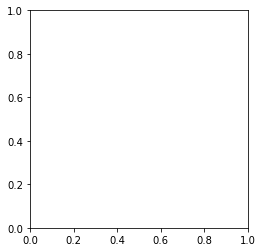

In [29]:
plt.imshow(img)
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.axis('off')

In [38]:
coco = COCO('/n/fs/visualai-scr/Data/Coco/2014data/annotations/instances_val2014.json')
img_dir = '/n/fs/visualai-scr/Data/Coco/2014data/val2014'
image_id = 242365
gt_ann_ids = coco.getAnnIds(imgIds=[image_id])
anns = coco.loadAnns(gt_ann_ids)

img = coco.imgs[image_id]

mask = np.zeros(coco.annToMask(anns[1]).shape)
for i in range(len(anns)):
    if anns[i]['category_id']==1:
        mask += coco.annToMask(anns[i])

person_seg_mask = np.squeeze(transform(Image.fromarray(mask)))

#and 
INTERSECTION = np.sum(np.bitwise_and(np.array(person_seg_mask)>0, np.array(heatmap)>0))
# or 
UNION = np.sum(np.bitwise_or(np.array(person_seg_mask)>0, np.array(heatmap)>0))
IOU = INTERSECTION/UNION
print(IOU)

loading annotations into memory...
Done (t=5.84s)
creating index...
index created!
0.15600816232241174


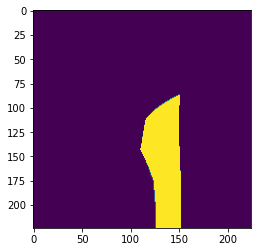

In [39]:
plt.imshow(np.bitwise_and(np.array(person_seg_mask)>0, np.array(heatmap)>0))

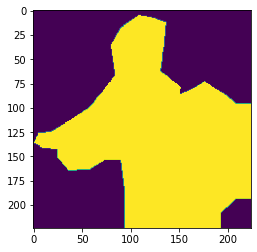

In [40]:
plt.imshow(np.bitwise_or(np.array(person_seg_mask)>0, np.array(heatmap)>0))

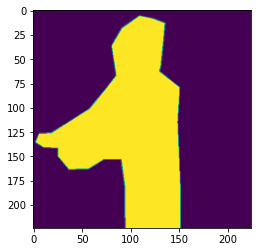

In [36]:
plt.imshow(heatmap)
plt.imshow(person_seg_mask)

In [189]:
coco = COCO('/n/fs/visualai-scr/Data/Coco/2014data/annotations/instances_val2014.json')
img_dir = '/n/fs/visualai-scr/Data/Coco/2014data/val2014'
image_id = 242365
img = coco.imgs[image_id]

loading annotations into memory...
Done (t=5.73s)
creating index...
index created!


(-0.5, 223.5, 223.5, -0.5)

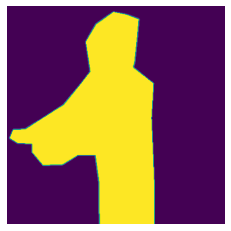

In [22]:
mask = np.zeros(coco.annToMask(anns[1]).shape)
for i in range(len(anns)):
    if anns[i]['category_id']==1:
        mask += coco.annToMask(anns[i])


plt.imshow(np.squeeze(transform(Image.fromarray(mask))))
plt.axis('off')

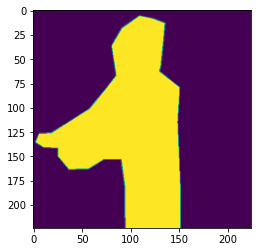

In [252]:
person_seg_mask = np.squeeze(transform(Image.fromarray(mask)))
plt.imshow(person_seg_mask)

In [259]:
#and 
np.sum(np.bitwise_and(np.array(person_seg_mask)>0, np.array(heatmap)>0))
# or 
np.sum(np.bitwise_or(np.array(person_seg_mask)>0, np.array(heatmap)>0))

(4052, 25973)